In [121]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from random import randint

from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog

from sklearn.model_selection import GridSearchCV
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle

In [145]:
vehicles = glob.glob('./data/vehicles/*/*.png')
nonvehicles = glob.glob('./data/non-vehicles/*/*.png')

In [144]:
len(nonvehicles)

11968

In [146]:
def extract_spatial_bin_features(img, size=(32,32)):
    return cv2.resize(img, size).ravel()

def image_cspace(img, colorspace='RGB'):
    img_cspace = None
    if colorspace == 'HSV':
        img_cspace = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif colorspace == 'RGB':
        img_cspace = np.copy(img)
    elif colorspace == 'YCrCb':
        img_cspace = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif colorspace == 'YUV':
        img_cspace = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif colorspace == 'HLS':
        img_cspace = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif colorspace == 'GRAY':
        img_cspace = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        print('Color space error')
    return img_cspace

def extract_color_hist(img, bins=32):
    c = [np.histogram(img[:,:,i], bins=bins, range=(0,256))[0] for i in range(3)]
    return np.concatenate(c)

def extract_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, 
                        feature_vec=True, vis=False):
    if vis == True:
        features, hog_image = hog(img, 
                                  orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, 
                                  feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def extract_features(files):
    num = 10
    i = 0
    colorspace = 'YCrCb'
#    colorspace = 'RGB'
    featVecList = []
    for f in files:
        img = mpimg.imread(f)
        img_cspace = image_cspace(img, colorspace)
        colhist = extract_color_hist(img_cspace)
        hogfeat = []
        for c in range(img_cspace.shape[2]):
            hogfeat.append(extract_hog_features(img_cspace[:,:,c]))
        hogfeatures = np.ravel(hogfeat)
        spatial_bin_features = extract_spatial_bin_features(img_cspace)
        
        features_all = np.concatenate((np.float32(colhist), np.float32(hogfeatures), np.float32(spatial_bin_features)))
        featVecList.append(features_all)
        i = i + 1
        # if i >= num:
        #    break
    return np.vstack(featVecList)
                        

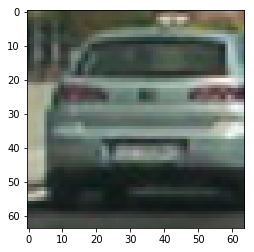

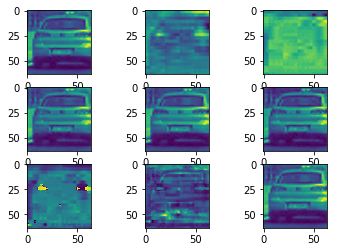

In [65]:
imgt = mpimg.imread(vehicles[250])
imgt_cspace = image_cspace(imgt, 'YCrCb')

plt.figure()
plt.imshow(imgt)

fig = plt.figure()
a = fig.add_subplot(3,3,1)
plt.imshow(imgt_cspace[:,:,0])
a = fig.add_subplot(3,3,2)
plt.imshow(imgt_cspace[:,:,1])
a = fig.add_subplot(3,3,3)
plt.imshow(imgt_cspace[:,:,2])

a = fig.add_subplot(3,3,4)
plt.imshow(imgt[:,:,0])
a = fig.add_subplot(3,3,5)
plt.imshow(imgt[:,:,1])
a = fig.add_subplot(3,3,6)
plt.imshow(imgt[:,:,2])

imgt_cspace = image_cspace(imgt, 'HSV')
a = fig.add_subplot(3,3,7)
plt.imshow(imgt_cspace[:,:,0])
a = fig.add_subplot(3,3,8)
plt.imshow(imgt_cspace[:,:,1])
a = fig.add_subplot(3,3,9)
plt.imshow(imgt_cspace[:,:,2])




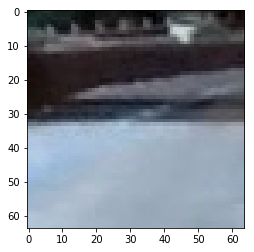

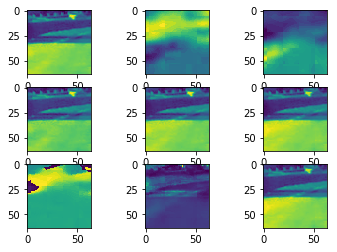

In [66]:
imgt = mpimg.imread(nonvehicles[1])
imgt_cspace = image_cspace(imgt, 'YCrCb')

plt.figure()
plt.imshow(imgt)

fig = plt.figure()
a = fig.add_subplot(3,3,1)
plt.imshow(imgt_cspace[:,:,0])
a = fig.add_subplot(3,3,2)
plt.imshow(imgt_cspace[:,:,1])
a = fig.add_subplot(3,3,3)
plt.imshow(imgt_cspace[:,:,2])

a = fig.add_subplot(3,3,4)
plt.imshow(imgt[:,:,0])
a = fig.add_subplot(3,3,5)
plt.imshow(imgt[:,:,1])
a = fig.add_subplot(3,3,6)
plt.imshow(imgt[:,:,2])

imgt_cspace = image_cspace(imgt, 'HSV')
a = fig.add_subplot(3,3,7)
plt.imshow(imgt_cspace[:,:,0])
a = fig.add_subplot(3,3,8)
plt.imshow(imgt_cspace[:,:,1])
a = fig.add_subplot(3,3,9)
plt.imshow(imgt_cspace[:,:,2])




In [24]:
def get_train_test_files(rootdir, trainfrac=0.8):
    trainfiles = []
    testfiles = []
    for folder in glob.glob(rootdir + '*'):
        files = glob.glob(folder + '/*.png')
        ind = int(trainfrac * len(files))
        trainfiles.extend(files[0:ind])
        testfiles.extend(files[ind:])
    return trainfiles, testfiles

In [124]:
%%time
train_files_pos, test_files_pos = get_train_test_files('./data/vehicles/')
train_files_neg, test_files_neg = get_train_test_files('./data/non-vehicles/')
X_train_pos = extract_features(train_files_pos)
y_train_pos = np.ones(X_train_pos.shape[0])
X_train_neg = extract_features(train_files_neg)
y_train_neg = np.zeros(X_train_neg.shape[0])
X_test_pos = extract_features(test_files_pos)
y_test_pos = np.ones(X_test_pos.shape[0])
X_test_neg = extract_features(test_files_neg)
y_test_neg = np.zeros(X_test_neg.shape[0])

X_train_ = np.concatenate((X_train_pos, X_train_neg))
y_train_ = np.concatenate((y_train_pos, y_train_neg))

X_test_ = np.concatenate((X_test_pos, X_test_neg))
y_test_ = np.concatenate((y_test_pos, y_test_neg))

X_train, y_train = shuffle(X_train_, y_train_, random_state=0)
X_test, y_test = shuffle(X_test_, y_test_, random_state=0)

CPU times: user 1min 47s, sys: 7.86 s, total: 1min 55s
Wall time: 2min 42s


In [125]:
tmp = extract_features(nonvehicles[1:3])

In [147]:
%%time
X_1 = extract_features(vehicles)
y_1 = np.ones(X_1.shape[0])
X_0 = extract_features(nonvehicles)
y_0 = np.zeros(X_0.shape[0])

X = np.concatenate((X_1, X_0))
y = np.concatenate((y_1, y_0))

CPU times: user 1min 49s, sys: 7.27 s, total: 1min 56s
Wall time: 2min 45s


In [148]:
seed = randint(0, 100)
print(seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=seed)

28


In [149]:
(X_test.shape, y_test.shape)

((4152, 8460), (4152,))

In [150]:
X_scaler = StandardScaler().fit(X_train)

In [151]:
X_train_scaled = X_scaler.transform(X_train)

In [152]:
X_test_scaled = X_scaler.transform(X_test)

In [153]:
svc = LinearSVC(C=0.001)

In [154]:
%%time
m = svc.fit(X_train_scaled, y_train)


CPU times: user 9.34 s, sys: 13.1 s, total: 22.4 s
Wall time: 37 s


In [155]:
svc.score(X_test_scaled, y_test)

0.99253371868978801

In [24]:
#### Search

In [69]:
imgrand = mpimg.imread(vehicles[250])

In [70]:
imgrand.shape

(64, 64, 3)

In [77]:
imgrandc = image_cspace(imgrand, 'HSV')

hog_f = []
hog_img = []
for i in range(3):
    f, himg = extract_hog_features(imgrandc[:,:,i], cell_per_block=2, feature_vec=False, vis=True)
    hog_f.append(f)
    hog_img.append(himg)

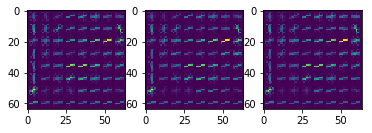

In [84]:
fig = plt.figure()
for i in range(3):
    a = fig.add_subplot(1,3,i+1)
    plt.imshow(hog_img[i])


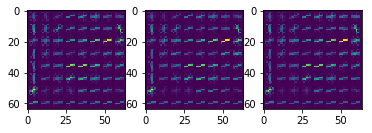

In [89]:
imgrandc = image_cspace(imgrand, 'RGB')
fig = plt.figure()
for i in range(3):
    f, himg = extract_hog_features(imgrandc[:,:,i], cell_per_block=2, feature_vec=False, vis=True)
    a = fig.add_subplot(1,3, i+1)
    plt.imshow(himg)
    

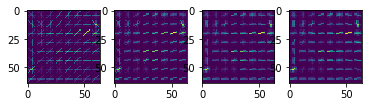

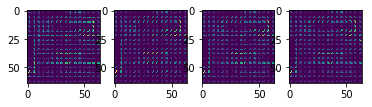

In [116]:
imgrandc = image_cspace(imgrand, 'GRAY')
fig = plt.figure()
f, h4 = extract_hog_features(imgrandc, cell_per_block=2, pix_per_cell=8, orient=4, feature_vec=False, vis=True)
f, h9 = extract_hog_features(imgrandc, cell_per_block=2, pix_per_cell=8, orient=9, feature_vec=False, vis=True)
f, h20 = extract_hog_features(imgrandc, cell_per_block=2, pix_per_cell=8, orient=20, feature_vec=False, vis=True)
f, h40 = extract_hog_features(imgrandc, cell_per_block=2, pix_per_cell=8, orient=40, feature_vec=False, vis=True)
a = fig.add_subplot(1,4,1)
plt.imshow(h4)
a = fig.add_subplot(1,4,2)
plt.imshow(h9)
a = fig.add_subplot(1,4,3)
plt.imshow(h20)
a = fig.add_subplot(1,4,4)
plt.imshow(h40)

fig = plt.figure()
f, h20_4 = extract_hog_features(imgrandc, cell_per_block=2, pix_per_cell=4, orient=4, feature_vec=False, vis=True)
f, h20_9 = extract_hog_features(imgrandc, cell_per_block=2, pix_per_cell=4, orient=9, feature_vec=False, vis=True)
f, h20_20 = extract_hog_features(imgrandc, cell_per_block=2, pix_per_cell=4, orient=20, feature_vec=False, vis=True)
f, h20_40 = extract_hog_features(imgrandc, cell_per_block=2, pix_per_cell=4, orient=40, feature_vec=False, vis=True)
a = fig.add_subplot(1,4,1)
plt.imshow(h20_4)
a = fig.add_subplot(1,4,2)
plt.imshow(h20_9)
a = fig.add_subplot(1,4,3)
plt.imshow(h20_20)
a = fig.add_subplot(1,4,4)
plt.imshow(h20_40)

In [156]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [35]:
test_img_files = glob.glob('./test_images/*.jpg')

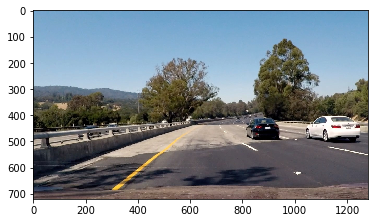

In [76]:
img_test = mpimg.imread(test_img_files[3])
plt.imshow(img_test)

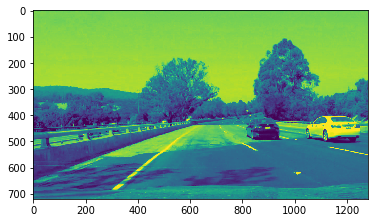

In [44]:
img_cspace = image_cspace(img_test, colorspace='HSV')
plt.imshow(img_cspace[:,:,2])

In [45]:
%%time
h, hog_img = extract_hog_features(img_cspace[:,:,0], feature_vec=False, vis=True)

CPU times: user 3.45 s, sys: 58 ms, total: 3.51 s
Wall time: 3.58 s


In [46]:
img_test.shape

(720, 1280, 3)

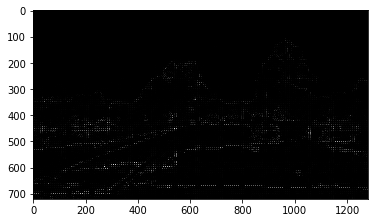

In [47]:
plt.imshow(hog_img, cmap='gray')

In [48]:
h_rgb, hog_img_rgb = extract_hog_features(img_test[:,:,0], feature_vec=False, vis=True)

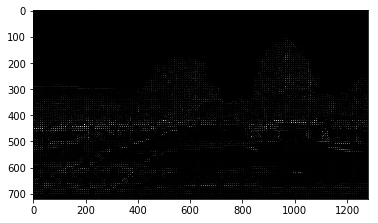

In [49]:

plt.imshow(hog_img_rgb, cmap='gray')

In [157]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=32, hist_bins=32):
    bboxes = []
    draw_img = np.copy(img)
    # For JPG image
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = image_cspace(img_tosearch, colorspace='YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(
                ctrans_tosearch, 
                (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    #window = 96
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = extract_spatial_bin_features(subimg, size=(spatial_size, spatial_size))
            hist_features = extract_color_hist(subimg, bins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hist_features, hog_features, spatial_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                test_distance = svc.decision_function(test_features)
#                if test_distance > 0.1:
#                    continue
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

                bbox = ((xbox_left, ytop_draw + ystart),
                        (xbox_left + win_draw, ytop_draw + ystart + win_draw))
                bboxes.append(bbox)
                
    return draw_img, bboxes

In [158]:
%%time
img_test = mpimg.imread(test_img_files[4])
img_test_c = image_cspace(img_test, 'RGB')

img_draw, bboxes = find_cars(img_test_c, ystart=400, ystop=800, scale=1, svc=svc, X_scaler=X_scaler )

CPU times: user 1.28 s, sys: 87.6 ms, total: 1.37 s
Wall time: 1.53 s


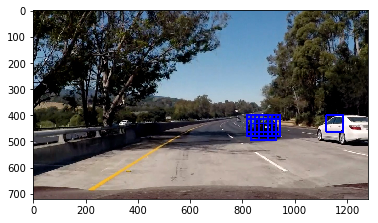

In [159]:
plt.imshow(img_draw)

In [160]:
len(bboxes)

13

In [60]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    labeled_bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        labeled_bboxes.append((car_number, bbox))
    # Return the image
    return img, labeled_bboxes


In [61]:
def duplicate_detection_by_heatmap(img_test, bboxes):
    heat = np.float32(np.zeros(img_test.shape[0:2]))
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat, 1)
    heat = np.clip(heat, 0, 255)
    labels = label(heat)
    img_test_with_labels, labeled_bboxes = draw_labeled_bboxes(np.copy(img_test), labels)
    return img_test_with_labels, labeled_bboxes

In [62]:
def show_side_by_side(im1, im2):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    f.set_size_inches(f.get_size_inches() * 2)
    f.set_figwidth(25)
    ax1.axis('off')
    ax2.axis('off')

    ax1.imshow(im1)
    ax2.imshow(im2)

In [63]:
def process_img_basic(img):
    img_draw, bboxes = find_cars(img, ystart=400, ystop=800, scale=1, svc=svc, X_scaler=X_scaler)
    return img_draw

def process_img(img):
    img_draw, bboxes = find_cars(img, ystart=400, ystop=800, scale=1, svc=svc, X_scaler=X_scaler)
    img_with_labels, labeled_bboxes = duplicate_detection_by_heatmap(img, bboxes)
    return img_with_labels


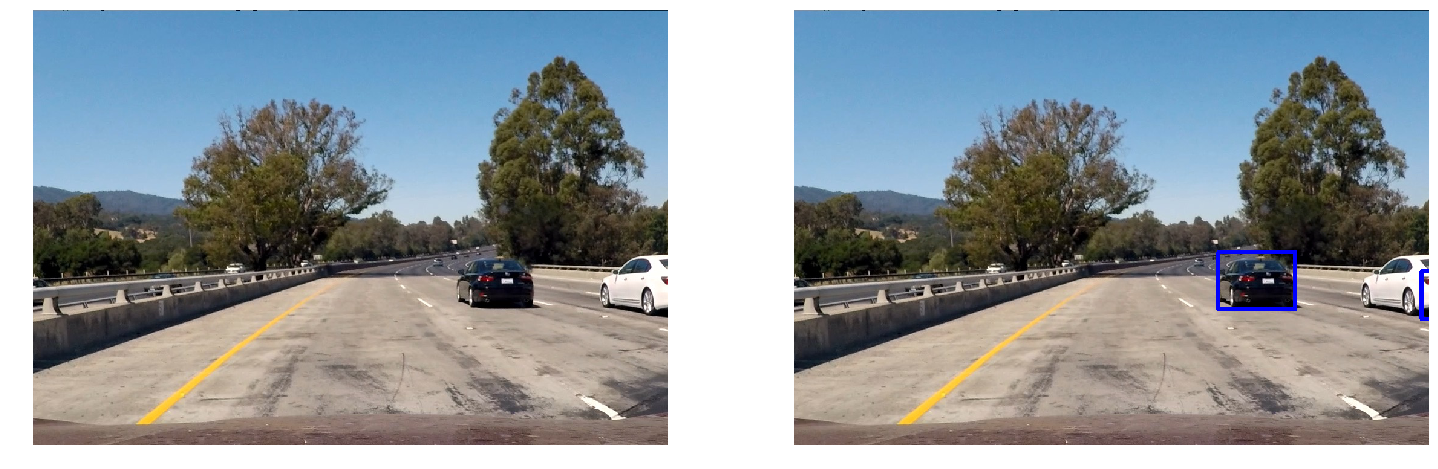

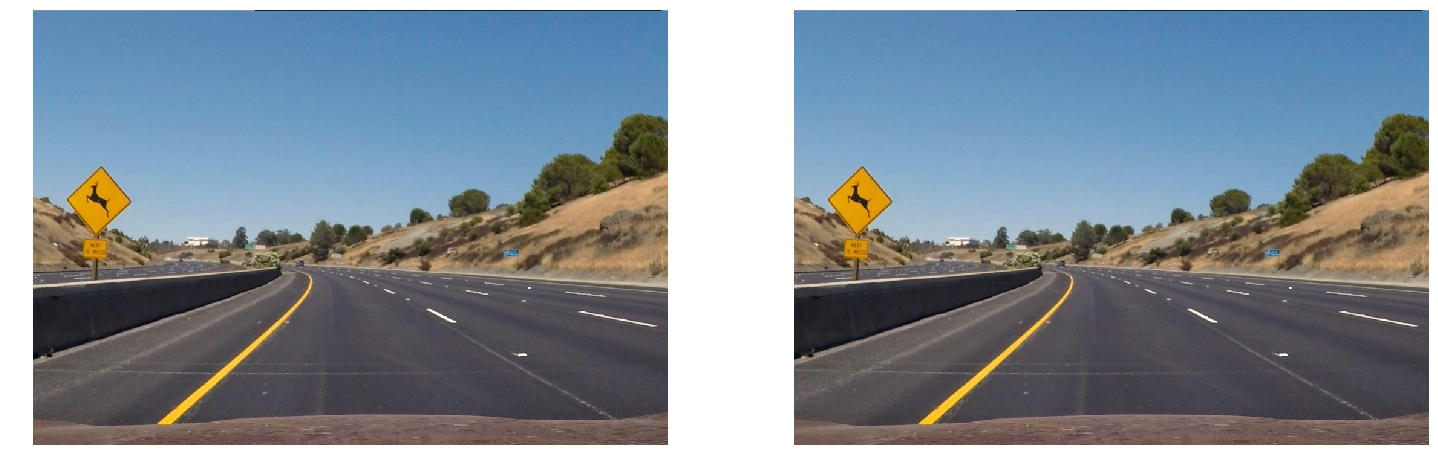

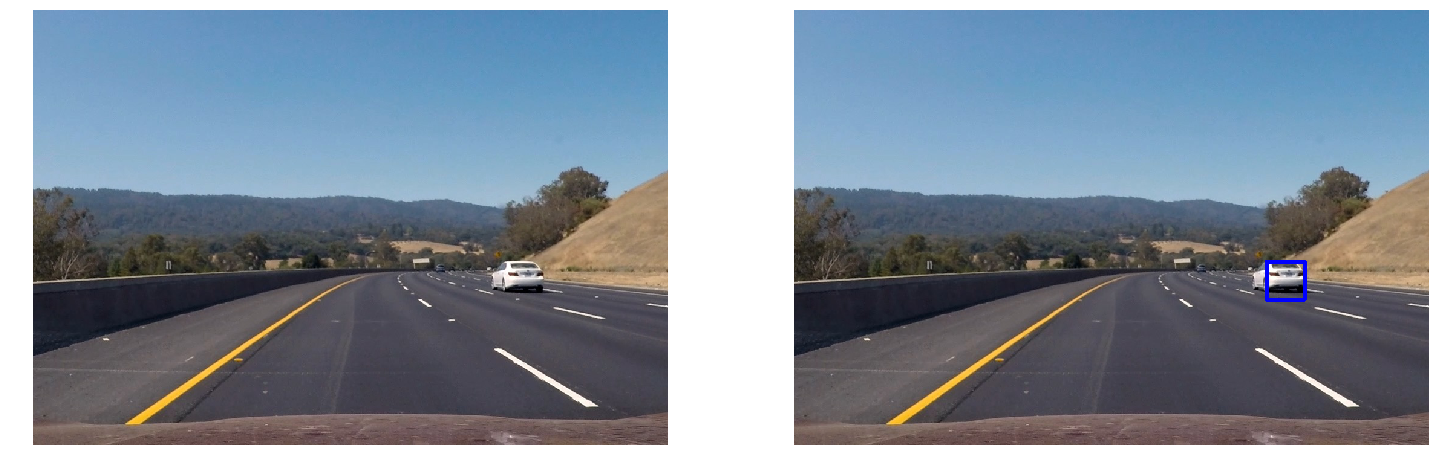

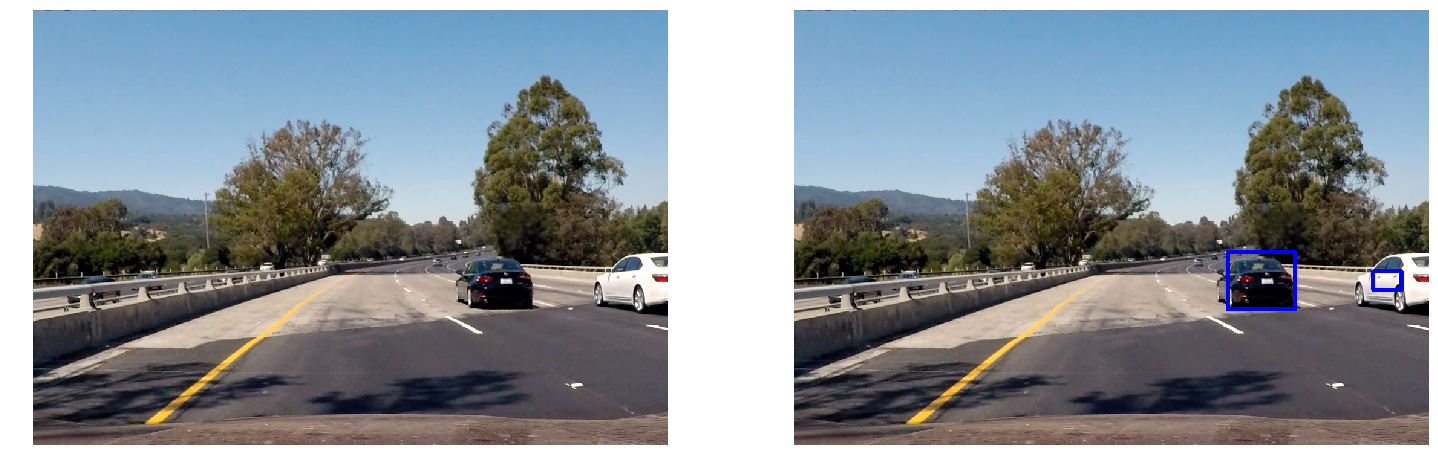

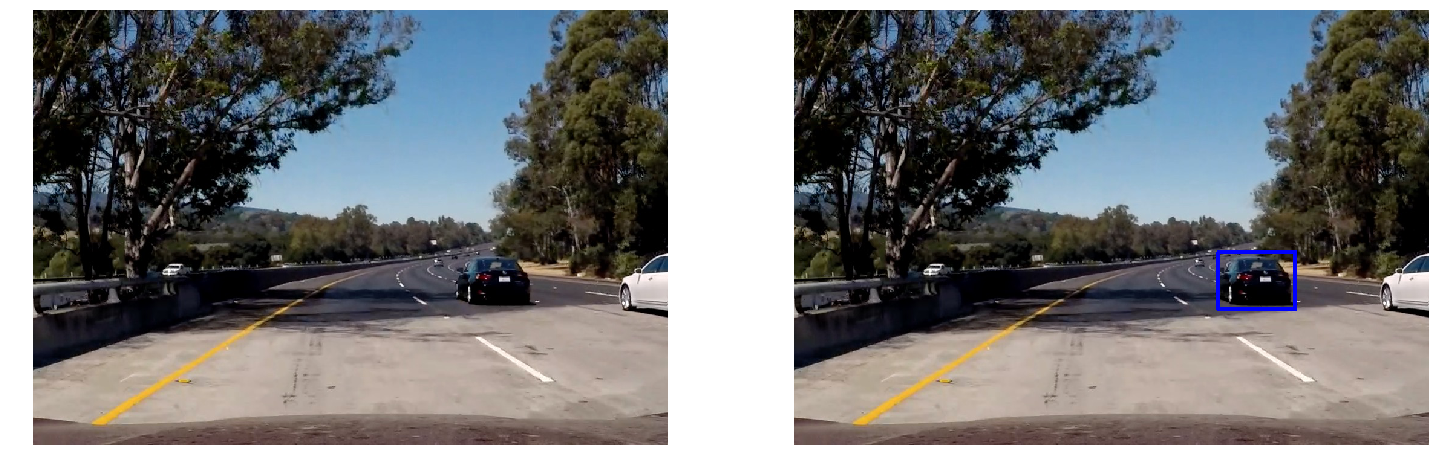

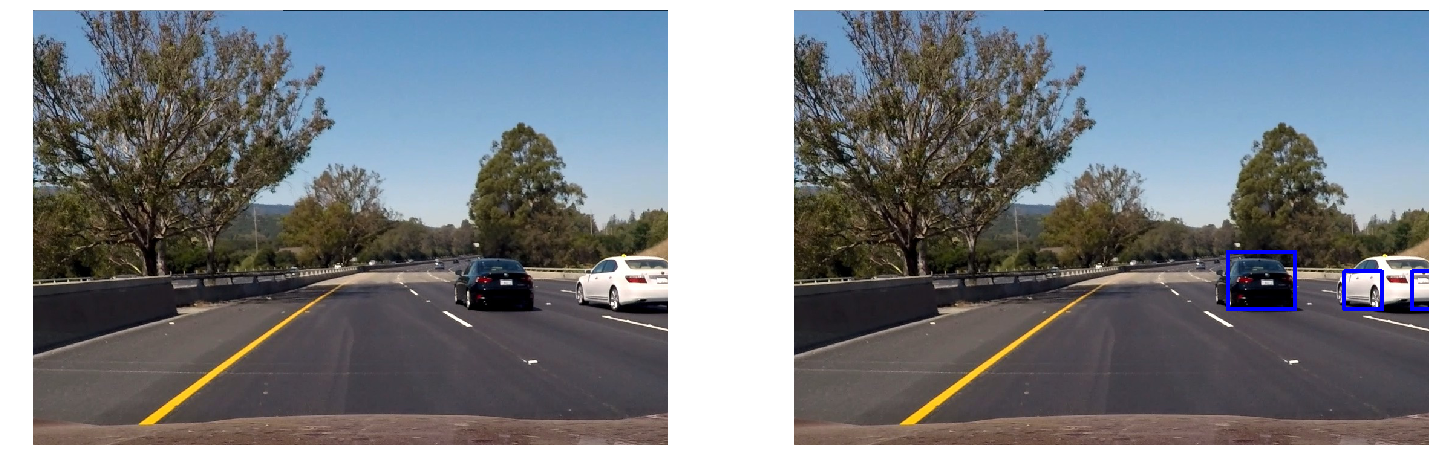

In [161]:
for f in test_img_files:
    img_test = mpimg.imread(f)
    imgout = process_img(img_test)
    show_side_by_side(img_test, imgout)


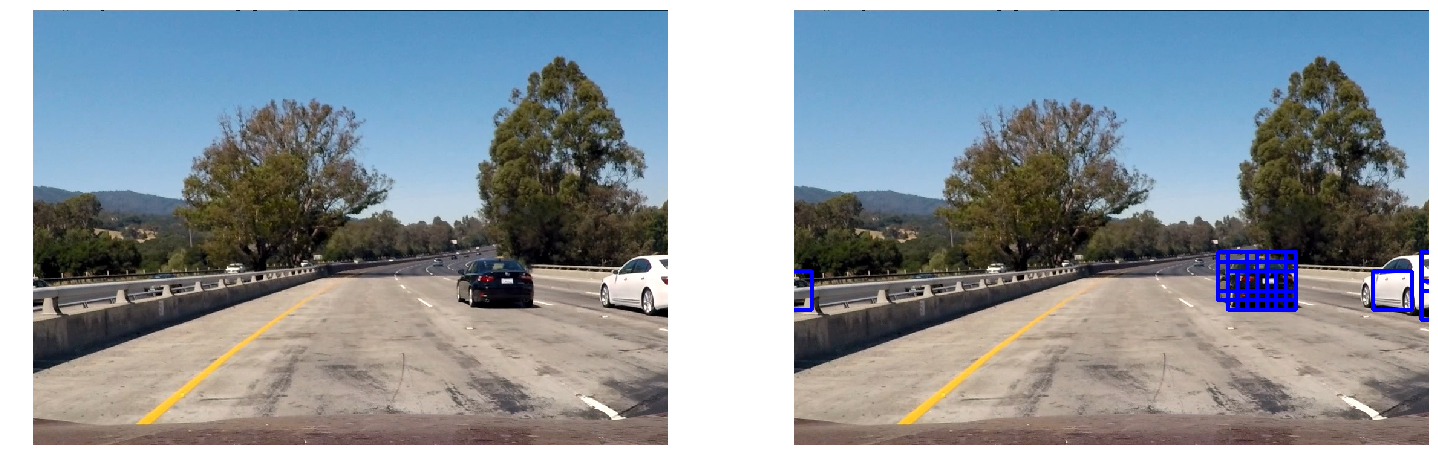

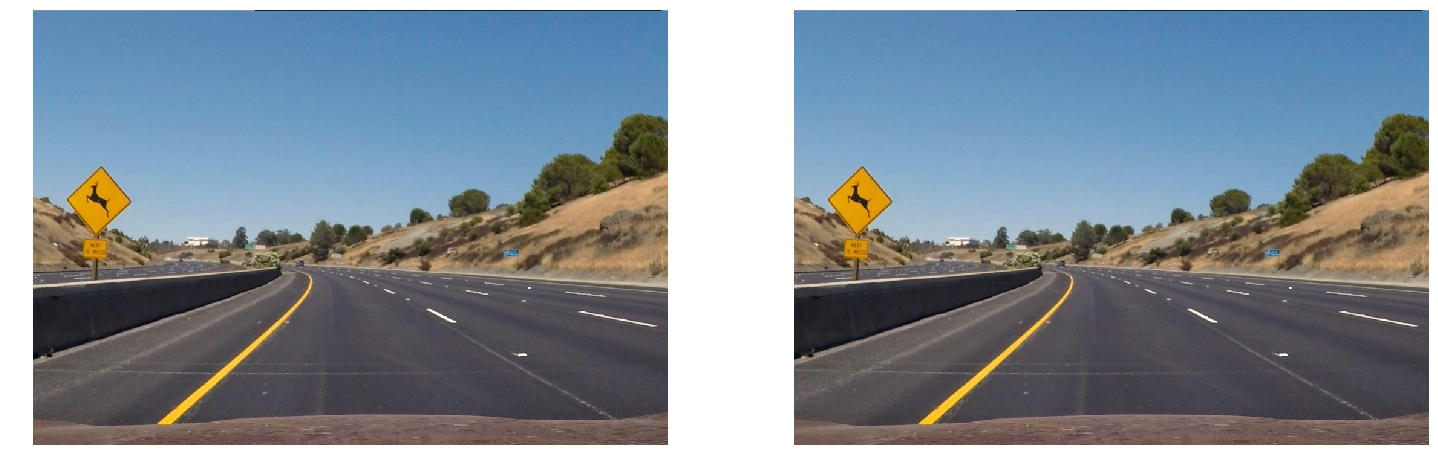

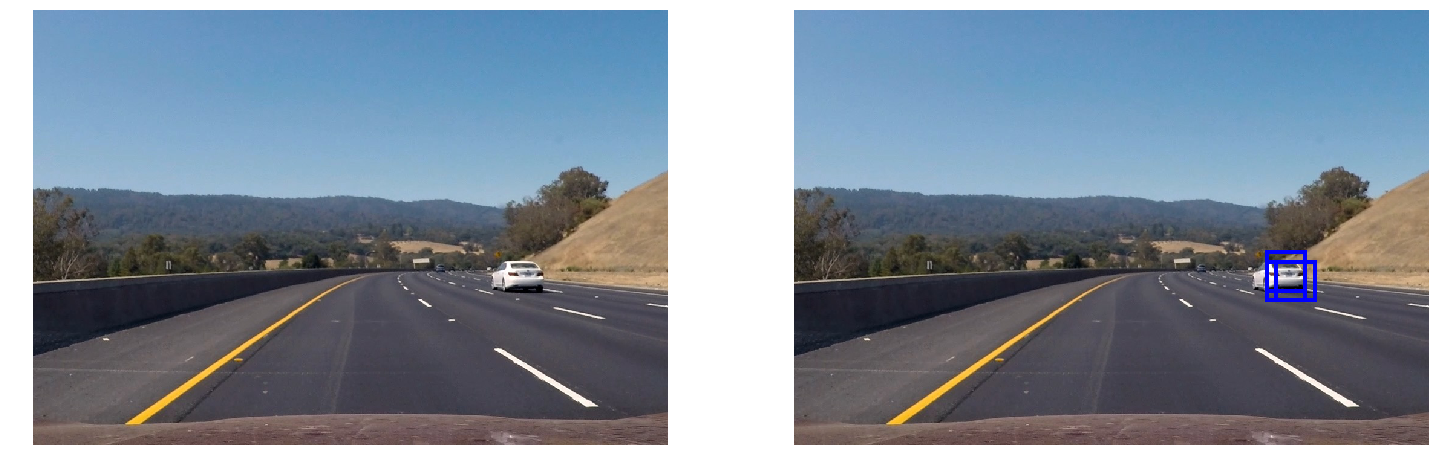

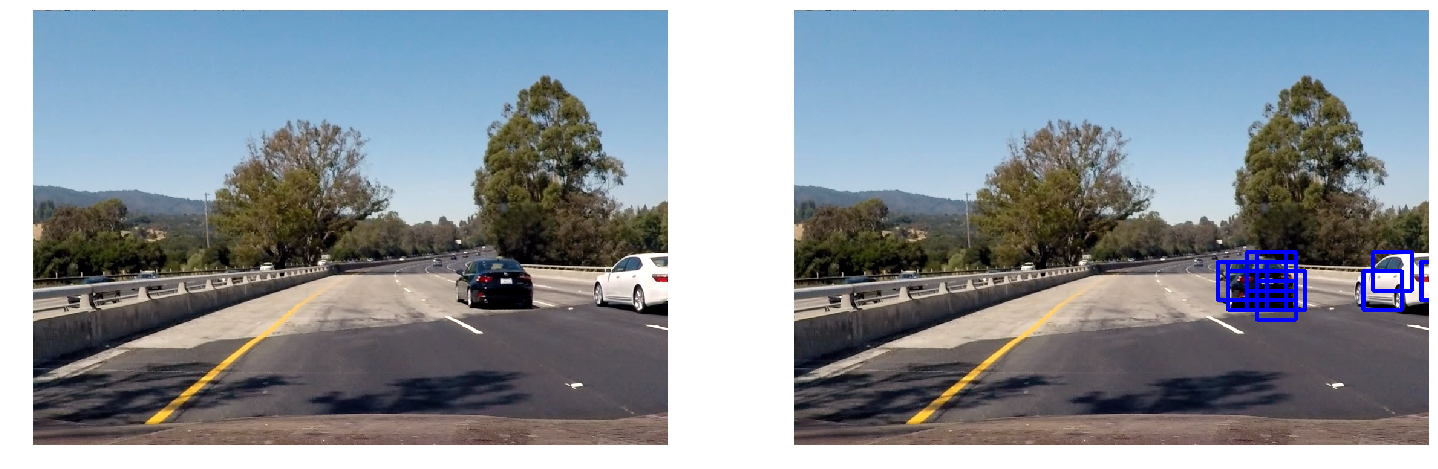

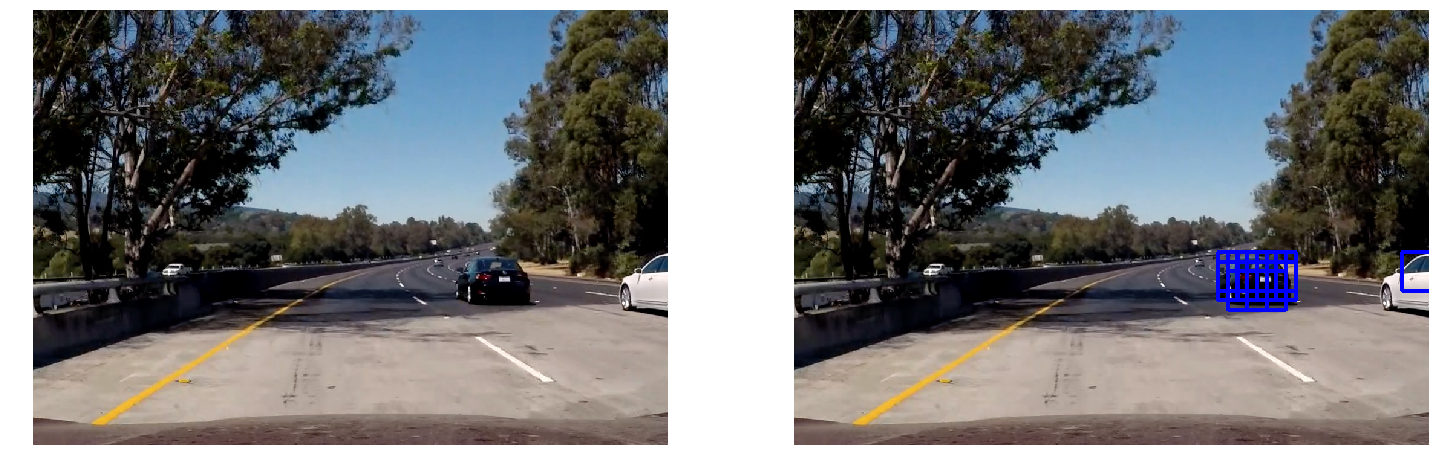

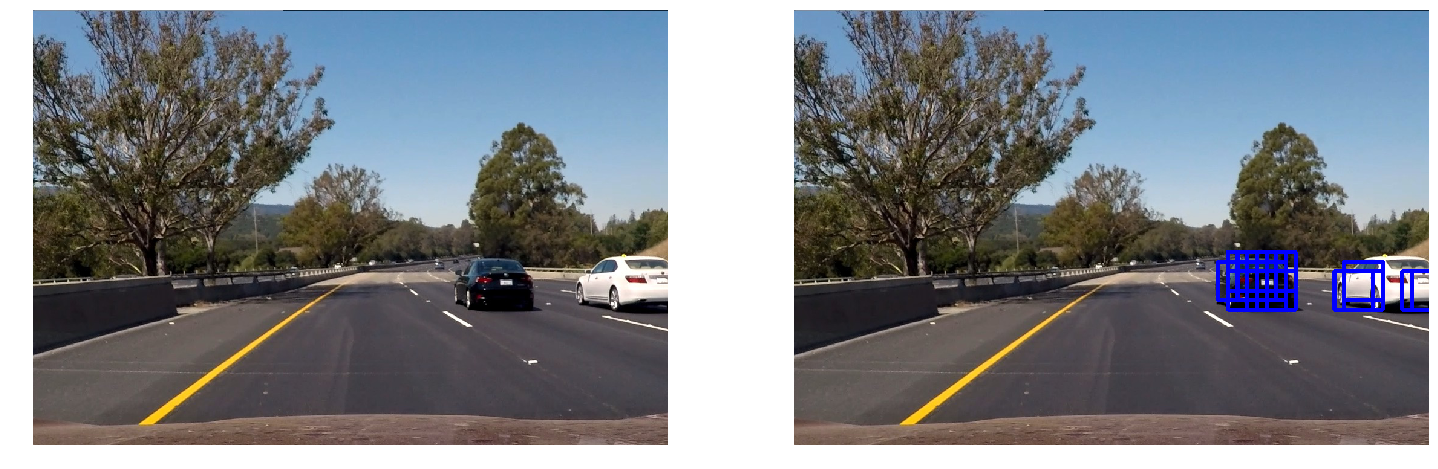

In [162]:
for f in test_img_files:
    img_test = mpimg.imread(f)
    imgout = process_img_basic(img_test)
    show_side_by_side(img_test, imgout)


In [166]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [60]:
movie_file ='./test_video.mp4'
movie_outfile = './test_video_out_steps_1.mp4'
clip1 = VideoFileClip(movie_file)

In [61]:
%%time
outclip = clip1.fl_image(process_img)

CPU times: user 3.53 s, sys: 67.5 ms, total: 3.6 s
Wall time: 3.64 s


In [62]:
%time outclip.write_videofile(movie_outfile, audio=False)

[MoviePy] >>>> Building video ./test_video_out_steps_1.mp4
[MoviePy] Writing video ./test_video_out_steps_1.mp4


 97%|█████████▋| 38/39 [02:51<00:05,  5.12s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_out_steps_1.mp4 

CPU times: user 2min 40s, sys: 3.03 s, total: 2min 43s
Wall time: 2min 54s


In [63]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(movie_outfile))

In [64]:
movie_file = './project_video.mp4'
movie_outfile = './project_video_out_tmp3.mp4'
# (5,15)
clip1 = VideoFileClip(movie_file).subclip(30, 31)

In [65]:
%%time
outclip = clip1.fl_image(process_img)

CPU times: user 3.64 s, sys: 64.6 ms, total: 3.7 s
Wall time: 3.73 s


In [66]:
%time outclip.write_videofile(movie_outfile, audio=False)

[MoviePy] >>>> Building video ./project_video_out_tmp3.mp4
[MoviePy] Writing video ./project_video_out_tmp3.mp4


 96%|█████████▌| 25/26 [01:33<00:03,  3.75s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out_tmp3.mp4 

CPU times: user 1min 30s, sys: 1.23 s, total: 1min 32s
Wall time: 1min 34s


In [67]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(movie_outfile))

In [163]:
from collections import deque

In [164]:
def draw_boxes(img, bboxes_labeled_list, color):
    img_to_draw_on = np.copy(img)
    for bboxes_labeled in bboxes_labeled_list:
        cv2.rectangle(img_to_draw_on, bboxes_labeled[1][0], bboxes_labeled[1][1], color, 6)
    return img_to_draw_on

def area_intersection(a, b):
    top_x = max(a[0][0], b[0][0])
    top_y = max(a[0][1], b[0][1])
    bottom_x = min(a[1][0], b[1][0])
    bottom_y = min(a[1][1], b[1][1])
    height = bottom_x - top_x + 1
    width = bottom_y - top_y + 1
    area = 0
    if height > 0 and width > 0:
        area = height * width
    return area

def count_num_overlap(box, buffer, area_threshold=0):
    num_overlap = 0
    for past_frame in buffer:
        for box_past_frame in past_frame:
            if area_intersection(box, box_past_frame[1]) > area_threshold:
                num_overlap += 1
    return num_overlap

    
def filter_tracking_overlap(labeled_bboxes, buffer, min_num_overlap):
    bboxes = []
    for b in labeled_bboxes:
        num_overlap = count_num_overlap(b[1], buffer)
        if num_overlap >= min_num_overlap:
            bboxes.append(b)
    return bboxes

buffer = deque()
buffer_max_frames = 10
def process_img_with_tracking(img):
    img_draw, bboxes = find_cars(img, ystart=400, ystop=800, scale=1, svc=svc, X_scaler=X_scaler)
    img_with_labels, labeled_bboxes = duplicate_detection_by_heatmap(img, bboxes)
    filtered_bboxes = filter_tracking_overlap(
        labeled_bboxes, 
        buffer, 
        min_num_overlap=0.5 * buffer_max_frames)
    img_with_labels_tracking = draw_boxes(img, filtered_bboxes, color=(0, 0, 255))
    if len(buffer) == buffer_max_frames:
        buffer.popleft()
        buffer.append(labeled_bboxes)
        assert len(buffer) == buffer_max_frames
    else:
        buffer.append(labeled_bboxes)
        assert len(buffer) <= buffer_max_frames
    return img_with_labels_tracking

In [167]:
movie_file = './project_video.mp4'
movie_outfile = './project_video_out_full_tracking_3_YCrCb.mp4'
# (5,15)
# (20,23)
# (30,35)
# .subclip(30,35)
clip1 = VideoFileClip(movie_file)

In [168]:
%%time
buffer = deque()
outclip = clip1.fl_image(process_img_with_tracking)

CPU times: user 1.21 s, sys: 55.7 ms, total: 1.26 s
Wall time: 1.28 s


In [169]:
%time outclip.write_videofile(movie_outfile, audio=False)

[MoviePy] >>>> Building video ./project_video_out_full_tracking_3_YCrCb.mp4
[MoviePy] Writing video ./project_video_out_full_tracking_3_YCrCb.mp4


100%|█████████▉| 1260/1261 [26:30<00:01,  1.22s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out_full_tracking_3_YCrCb.mp4 

CPU times: user 25min 5s, sys: 49.1 s, total: 25min 54s
Wall time: 26min 31s


In [73]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(movie_outfile))

In [265]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(movie_outfile))

In [65]:
movie_file = './project_video.mp4'
movie_outfile = './project_video_out_tmp2_filtering.mp4'
# (5,15)
clip1 = VideoFileClip(movie_file).subclip(20,23)

In [66]:
%%time
buffer = deque()
outclip = clip1.fl_image(process_img_with_tracking)

CPU times: user 1.45 s, sys: 75.1 ms, total: 1.52 s
Wall time: 1.66 s


In [67]:
%time outclip.write_videofile(movie_outfile, audio=False)

[MoviePy] >>>> Building video ./project_video_out_tmp2_filtering.mp4
[MoviePy] Writing video ./project_video_out_tmp2_filtering.mp4


 99%|█████████▊| 75/76 [01:43<00:01,  1.58s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out_tmp2_filtering.mp4 

CPU times: user 1min 34s, sys: 3.43 s, total: 1min 37s
Wall time: 1min 45s


In [68]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(movie_outfile))